<a href="https://colab.research.google.com/github/albielee/Realtime_Animal_Tracking/blob/main/BackgroundSubtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install colabcode

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.0

Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 307kB 12.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (562/562), done.
/content/Mask_RCNN
     |████████████████████████████████| 204kB 13.7MB/s 
     |████████████████████████████████| 163kB 27.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=da84e8c1b5bdb806467b577ebb7852c208dc019a6f575069da804cfbabcd1b7a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore

In [4]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/Mask_RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Mask_RCNN/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
from skimage import io

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [6]:
class AnimalConfig(Config):
    # Give the configuration a recognizable name
    NAME = "animal_segmentation"
    
    NUM_CLASSES = 1 + 8

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = AnimalConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DI4zuCywm1t30WEwKU3DecCqzNEoeqNY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DI4zuCywm1t30WEwKU3DecCqzNEoeqNY" -O Images.zip && rm -rf /tmp/cookies.txt

--2021-04-10 07:47:11--  https://docs.google.com/uc?export=download&confirm=0eFe&id=1DI4zuCywm1t30WEwKU3DecCqzNEoeqNY
Resolving docs.google.com (docs.google.com)... 173.194.79.139, 173.194.79.100, 173.194.79.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-a8-docs.googleusercontent.com/docs/securesc/1e88hv67bstj001ealljomhfduc1dvro/leq0crjpifnrt1seg8vdm67nk1sv333c/1618040775000/05010576264562910306/03289653957286363592Z/1DI4zuCywm1t30WEwKU3DecCqzNEoeqNY?e=download [following]
--2021-04-10 07:47:11--  https://doc-0c-a8-docs.googleusercontent.com/docs/securesc/1e88hv67bstj001ealljomhfduc1dvro/leq0crjpifnrt1seg8vdm67nk1sv333c/1618040775000/05010576264562910306/03289653957286363592Z/1DI4zuCywm1t30WEwKU3DecCqzNEoeqNY?e=download
Resolving doc-0c-a8-docs.googleusercontent.com (doc-0c-a8-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connectin

In [8]:
!unzip Images.zip

Archive:  Images.zip
  inflating: Data/coco_labels_chimps.json  
   creating: Data/test/
  inflating: Data/test/bear10.jpg    
  inflating: Data/test/bear100.jpg   
  inflating: Data/test/bear101.jpg   
  inflating: Data/test/bear102.jpg   
  inflating: Data/test/bear103.jpg   
  inflating: Data/test/bear104.jpg   
  inflating: Data/test/bear105.jpg   
  inflating: Data/test/bear106.jpg   
  inflating: Data/test/bear107.jpg   
  inflating: Data/test/bear108.jpg   
  inflating: Data/test/bear109.jpg   
  inflating: Data/test/bear110.jpg   
  inflating: Data/test/bear111.jpg   
  inflating: Data/test/bear112.jpg   
  inflating: Data/test/bear114.jpg   
  inflating: Data/test/bear115.jpg   
  inflating: Data/test/bear116.jpg   
  inflating: Data/test/bear117.jpg   
  inflating: Data/test/bear118.jpg   
  inflating: Data/test/bear119.jpg   
  inflating: Data/test/bear120.jpg   
  inflating: Data/test/bear121.jpg   
  inflating: Data/test/bear122.jpg   
  inflating: Data/test/bear123.jpg   

In [9]:
class AnimalDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'Head')
        self.add_class('dataset', 2, 'Arm')
        self.add_class('dataset', 3, 'Body')
        self.add_class('dataset', 4, 'Chimp')
        self.add_class('dataset', 5, 'BearHead')
        self.add_class('dataset', 6, 'BearLeg')
        self.add_class('dataset', 7, 'BearBody')
        self.add_class('dataset', 8, 'Bear')
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        masks = np.zeros([600, 800, len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([600, 800], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [10]:
# Create training and validation set
# train set
dataset_train = AnimalDataset()
dataset_train.load_dataset('/content/Mask_RCNN/Data/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# test/val set
dataset_val = AnimalDataset()
dataset_val.load_dataset('/content/Mask_RCNN/Data/val')
dataset_val.prepare()
print('Val: %d' % len(dataset_val.image_ids))

Train: 90
Val: 10


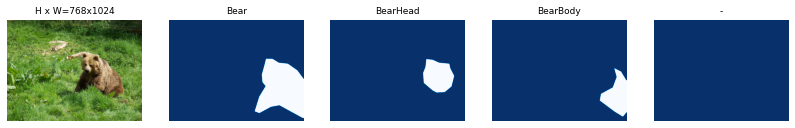

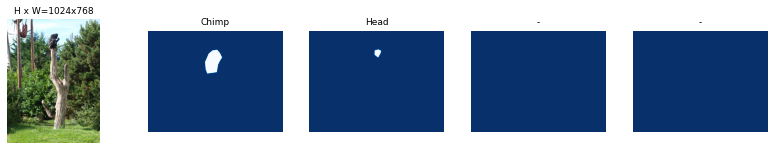

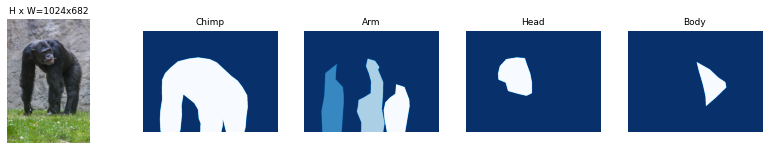

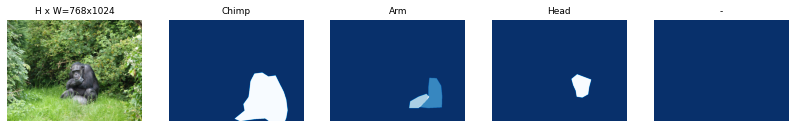

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/animal_segmentation20210410T0747/mask_rcnn_animal_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 999/1000 [============================>.] - ETA: 0s - loss: 1.5299 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.3673

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 300s 300ms/step - loss: 1.5291 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.3970 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.3672 - val_loss: 1.5318 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.4306 - val_mrcnn_class_loss: 0.3458 - val_mrcnn_bbox_loss: 0.4137 - val_mrcnn_mask_loss: 0.3301
Epoch 2/5
1000/1000 [==============================] - 228s 228ms/step - loss: 0.8117 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1997 - mrcnn_class_loss: 0.1804 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2612 - val_loss: 1.6663 - val_rpn_class_loss: 0.0141 - val_rpn_bbox_loss: 0.5635 - val_mrcnn_class_loss: 0.3673 - val_mrcnn_bbox_loss: 0.3809 - val_mrcnn_mask_loss: 0.3404
Epoch 3/5
1000/1000 [==============================] - 227s 227ms/step - loss: 0.5996 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2203 - val_loss: 1.6873 - val_rpn_clas

In [15]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 5. LR=0.0001

Checkpoint Path: /content/logs/animal_segmentation20210410T0747/mask_rcnn_animal_segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2749 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1330

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 405s 405ms/step - loss: 0.2749 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1330 - val_loss: 1.9054 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 0.6046 - val_mrcnn_class_loss: 0.4913 - val_mrcnn_bbox_loss: 0.3620 - val_mrcnn_mask_loss: 0.4337
Epoch 7/10
1000/1000 [==============================] - 353s 353ms/step - loss: 0.2381 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1221 - val_loss: 1.8622 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.5084 - val_mrcnn_class_loss: 0.5239 - val_mrcnn_bbox_loss: 0.3599 - val_mrcnn_mask_loss: 0.4605
Epoch 8/10
1000/1000 [==============================] - 354s 354ms/step - loss: 0.2193 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1142 - val_loss: 1.9293 - val_rpn_cla

In [16]:
class InferenceConfig(AnimalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weightss
#model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/animal_segmentation20210410T0747/mask_rcnn_animal_segmentation_0010.h5
Re-starting from epoch 10


In [17]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [22]:
"""
import keras
import json

def save_model(trained_model, out_fname="model.json"):
    jsonObj = trained_model.keras_model.to_json()
    with open(out_fname, "w") as fj:
        fj.write(jsonObj)
 
save_model(model, "/content/BearChimpModel.json")"""

'\nimport keras\nimport json\n\ndef save_model(trained_model, out_fname="model.json"):\n    jsonObj = trained_model.keras_model.to_json()\n    with open(out_fname, "w") as fj:\n        fj.write(jsonObj)\n \nsave_model(model, "/content/BearChimpModel.json")'

In [20]:
from PIL import Image
from PIL import ImageChops
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [24]:
#test = glob.glob('/content/Data/test/*.jpg')#.append(glob.glob('/content/Data/train/*.jpg'))
"""
file_names = next(os.walk("/content/Data/test/"))[2]
image = skimage.io.imread(os.path.join("/content/Data/test/", random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
#img = load_img("/content/Data/test/"+str(filename))
#img = img_to_array(img)
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#r = model.detect([img])

#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                          class_names, r['scores'])

#inp = input()
#if(inp == "y"):
  #save image
#  pass
#else:
  #disregard
#  pass"""


'\nfile_names = next(os.walk("/content/Data/test/"))[2]\nimage = skimage.io.imread(os.path.join("/content/Data/test/", random.choice(file_names)))\n\n# Run detection\nresults = model.detect([image], verbose=1)\n\n# Visualize results\nr = results[0]\nvisualize.display_instances(image, r[\'rois\'], r[\'masks\'], r[\'class_ids\'], \n                            class_names, r[\'scores\'])\n#img = load_img("/content/Data/test/"+str(filename))\n#img = img_to_array(img)\n#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))\n#r = model.detect([img])\n\n#visualize.display_instances(image, r[\'rois\'], r[\'masks\'], r[\'class_ids\'], \n#                          class_names, r[\'scores\'])\n\n#inp = input()\n#if(inp == "y"):\n  #save image\n#  pass\n#else:\n  #disregard\n#  pass'

In [25]:
"""
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#'visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
 #                           dataset_train.class_names, figsize=(8, 8))


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(img)
plt.show()

#returns image
#import cv2

# opencv loads the image in BGR, convert it to RGB
#img = original_image
#mask = cv2.imread("maskImage.png")
#final = cv2.bitwise_and(img, mask)
#cv2.imwrite("final.png", final)"""

'\n# Test on a random image\nimage_id = random.choice(dataset_val.image_ids)\noriginal_image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(dataset_val, inference_config, \n                           image_id, use_mini_mask=False)\n\nlog("original_image", original_image)\nlog("image_meta", image_meta)\nlog("gt_class_id", gt_class_id)\nlog("gt_bbox", gt_bbox)\nlog("gt_mask", gt_mask)\n\n#\'visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, \n #                           dataset_train.class_names, figsize=(8, 8))\n\n\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\nimgplot = plt.imshow(img)\nplt.show()\n\n#returns image\n#import cv2\n\n# opencv loads the image in BGR, convert it to RGB\n#img = original_image\n#mask = cv2.imread("maskImage.png")\n#final = cv2.bitwise_and(img, mask)\n#cv2.imwrite("final.png", final)'

In [19]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def get_trim_coords(im):
  remove_value = im[0][0]
  #top left
  left = 10000
  right = 0
  for line in im:
    c = 0
    in_mask = False
    for p in line:
      if not np.array_equal(p,remove_value):
        in_mask = True
        if c < left:
          left = c
      elif in_mask == True:
        in_mask = False
        if c > right:
          right = c
      c+=1

  top=10000
  bottom=0
  c = 0
  for line in im:
    in_mask = False
    for p in line:
      if not np.array_equal(p,remove_value):
        in_mask = True
        if c < top:
          top = c
    if in_mask == True:
      if c > bottom:
        bottom = c
    c+=1

  #right = right-left
  #bottom = bottom-top
  return left, right, top, bottom

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

def get_segment_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

In [60]:
import time
from PIL import ImageDraw
import skimage
from matplotlib.pyplot import figure, draw, pause

image_paths = []
train_dir = '/content/Mask_RCNN/Data/train'
for filename in os.listdir(train_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(train_dir, filename))
real_test_dir = '/content/Mask_RCNN/Data/test/'
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
val_dir = '/content/Mask_RCNN/Data/val/'
for filename in os.listdir(val_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(val_dir, filename))

bbox_count = 0
count = 0
for image_path in image_paths:
  img = skimage.io.imread(image_path)
  img_arr = np.array(img)

  results = model.detect([img_arr], verbose=1)
  
  r = results[0]
  N = r['rois'].shape[0]

  masked_image = img.astype(np.uint32).copy()
  merged_mask = np.array([[False]*img.shape[1]]*img.shape[0])
  for i in range(N):
      mask = np.array(r['masks'][:,:,i]).copy()
      merged_mask = np.ma.mask_or(merged_mask, mask)

  for c in range(3):
    masked_image[:,:,c] = np.where(merged_mask == 0,
                                  masked_image[:,:,c] * 1,
                                  masked_image[:,:,c])

  
  new_mask = [[[int(val == True)*255] for val in line] for line in merged_mask]
  rgba = np.concatenate((masked_image, new_mask), axis=2).astype(np.uint8)

  #new_image = [np.ix_(mask.any(1), mask.any(0))]#get_segment_crop(rgba, mask=merged_mask)
  im = Image.fromarray(rgba, 'RGBA')
  img_name = 'image'+str(count)+".png"

  im.save("/content/cropped_images/"+img_name, 'PNG')
  ################################################################################################

  #set image path
  with open('/content/images.csv','a+') as fd:
    fd.write("%s" % ('./model_data/image'+str(count)+'.png '))

  #for each mask get bounding box
  for i in range(N):
    bb = r['rois'][i]
    id = r['class_ids'][i]
    with open('/content/images.csv','a+') as fd:
      fd.write("%i,%i,%i,%i,%i " % (bb[0], bb[1], bb[2], bb[3], id))

  with open('/content/images.csv','a+') as fd:
      fd.write("\n")
  """
  for i in range(N):
    im_copy = img.astype(np.uint32).copy()
    mask = np.array(r['masks'][:,:,i]).copy()
    for c in range(3):
        im_copy[:,:,c] = np.where(mask == 0,
                                      im_copy[:,:,c] * 0,
                                      im_copy[:,:,c])
    new_mask = [[[int(val == True)*255] for val in line] for line in mask]
    rgba = np.concatenate((im_copy, new_mask), axis=2).astype(np.uint8)
    new_image = get_segment_crop(rgba, mask=mask)
    img_name = 'image'+str(bbox_count)+'.png'
    im = Image.fromarray(new_image, 'RGBA')
    im.save("/content/body_part_val/"+img_name, 'PNG')
    bbox_count+=1
  """
  count += 1



Streaming output truncated to the last 5000 lines.
Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 683, 3)        min:    0.00000  max:  241.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 683, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape:

In [61]:
!zip -r /content/cropped_images.zip /content/cropped_images/


  adding: content/cropped_images/ (stored 0%)
  adding: content/cropped_images/image214.png (deflated 0%)
  adding: content/cropped_images/image498.png (deflated 0%)
  adding: content/cropped_images/image820.png (deflated 0%)
  adding: content/cropped_images/image212.png (deflated 0%)
  adding: content/cropped_images/image871.png (deflated 0%)
  adding: content/cropped_images/image646.png (deflated 0%)
  adding: content/cropped_images/image465.png (deflated 0%)
  adding: content/cropped_images/image7.png (deflated 0%)
  adding: content/cropped_images/image435.png (deflated 0%)
  adding: content/cropped_images/image125.png (deflated 0%)
  adding: content/cropped_images/image324.png (deflated 0%)
  adding: content/cropped_images/image92.png (deflated 0%)
  adding: content/cropped_images/image48.png (deflated 0%)
  adding: content/cropped_images/image284.png (deflated 0%)
  adding: content/cropped_images/image553.png (deflated 0%)
  adding: content/cropped_images/image379.png (deflated 0%

In [ ]:



  """
  for i in range(N):
    mask = np.array(r['masks'][:,:,i]).copy()
    masked_image = img.astype(np.uint32).copy()

    #fig.add_subplot(rows, columns, 1)

    if not ax:
      fig, ax = plt.subplots(1, figsize=[9,9])
    height, width = img.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(dataset_val.class_names)


    #see what it looks like without background
    for c in range(3):
      masked_image[:,:,c] = np.where(mask == 0,
                                    masked_image[:,:,c] * 0.3,
                                    masked_image[:,:,c])
    

    # Label
    if not captions:
        class_id = r['class_ids'][i]
        score = r['scores'][i] if r['scores'] is not None else None
        label = dataset_val.class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
    else:
        caption = captions[i]
    ax.text(20, 20 + 8, caption,
            color='w', size=20, backgroundcolor="none")

    #update_subplot(masked_image.astype(np.uint8))
    ax.imshow(masked_image.astype(np.uint8))
    #s.set_data(masked_image.astype(np.uint8))

    #axim.set_data(masked_image.astype(np.uint8))
    #fig.canvas.flush_events()

    plt.show(block=False)
    #time.sleep(1)
    print("y or n!!")
    inp = 'y'
    if(inp == 'y'):
      fig.canvas.flush_events()
      #Fully remove background
      #rgba = np.insert(
      #  masked_image,
      #  3, #position in the pixel value [ r, g, b, a <-index [3]  ]
      #  255, # or 1 if you're going for a float data type as you want the alpha to be fully white otherwise the entire image will be transparent.
      #  axis=2, #this is the depth where you are inserting this alpha channel into
      #)

      
      for c in range(3):
        masked_image[:,:,c] = np.where(mask == 0,
                                      masked_image[:,:,c] * 0,
                                      masked_image[:,:,c])

      new_mask = [[[int(val == True)*255] for val in line] for line in mask]
      rgba = np.concatenate((masked_image, new_mask), axis=2).astype(np.uint8)

      new_image = get_segment_crop(rgba, mask=mask)
      im = Image.fromarray(new_image, 'RGBA')

      img_name = label+str(count)+".png"

      im.save("/content/cropped_images/"+img_name, 'PNG')
      count += 1
      

      #del masked_image[:]
      #del mask[:]
      #print(masked_image[267][166])
      #new_mask = []
      #for i in range(len(mask)):
      #  new_mask.append([])
      #  for j in range(len(mask[i])):
      #     new_mask[i].append([int(mask[i][j] == True)*255])


      #new_mask = mask.astype(int)
      #new_mask = [[int(mask[i][j] == True)*255] for i in mask for j in mask[i]]
     
      #print(new_mask.shape)
      #mask = np.expand_dims(mask, axis=(2,1))
      

      #im = Image.fromarray(rgba, 'RGBA')
      #trimmedImage = trim(thold)
      #Save the image
      #img_name = "image"+str(count)+".png"
      #matplotlib.image.imsave(img_name, im)
      #im.save(img_name, 'PNG')

      #print(rgba[279][180])
      #im = Image.fromarray(masked_image, 'RGB')
      #img_name = "image5"+str(count)+".png"
      #im.save(img_name)

      #m = Image.fromarray(mask, 'RGB')
      #Now crop to size
      #left, right, top, bottom = get_trim_coords(masked_image)

      #new_image = []
      #for i in range(len(masked_image)):
      #  if i > top and i < bottom:
      #    new_image.append(masked_image[i][left+1:right-1])
      #new_image = np.array(new_image)
      
      #print(new_image.shape)
      #print("LEFT",l," RIGHT",r, " TOP",t," BOTTOM",b)
      #masked_image = autocrop(masked_image)
     
      
      #no_alpha = im.convert('L')
      #bw = no_alpha.convert('L')
      #bg = Image.new('L', im.size, 255)
      #bbox = ImageChops.difference(bw, bg).getbbox()
      #if(bbox):
      #  im = im.crop(bbox)


      #no_alpha_bb = im.convert('RGB').getbbox()
      #print(no_alpha_bb)
      #cropped = im.crop(no_alpha_bb)
      #del new_image[:]
      #trimmedImage = trim(thold)
      #Save the image
      
      #matplotlib.image.imsave(img_name, cropped)
      #matplotlib.image.imsave(img_name, cropped)
      
    else:
      print("Skipped")
    """

"""
print("ROIS")
print(len(r['rois'][0]))
print("MASKSS")
print(len(r['masks'][0]))
print("CLASS IDS")
print(len(r['class_ids']))
print(len(dataset_val.class_names))
print(len(r['scores']))
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(10,10))
"""
#inp = input()

In [ ]:
"""
ax = None
count = 0
captions = None
bbox_count = 0
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    masked_image = img.astype(np.uint32).copy()
    results = model.detect([img_arr], verbose=1)
    
    r = results[0]
    N = r['rois'].shape[0]

    #find the class label that is either chimp or bear
    #animal_id = 0
    #for i in range(N):
    #  class_id = r['class_ids'][i]
    #  label = dataset_val.class_names[class_id]
    #  if(label == "chimp" or label == "bear"):
     #   animal_id = i

    #mask that represents all animal components
    #masks = np.array(r['masks'][:,:,:]).copy()
    #print(masks)
    merged_mask = [[False]*masked_image.shape[1]]*masked_image.shape[0]
    #print(merged_mask)
    for i in range(N):
        ma = np.array(r['masks'][:,:,i]).copy()
        merged_mask = np.ma.where(ma==1, merged_mask, ma)
    masked_image = img.astype(np.uint32).copy()

    #remove background
    for c in range(3):
          masked_image[:,:,c] = np.where(merged_mask == 0,
                                        masked_image[:,:,c] * 0,
                                        masked_image[:,:,c])
    
    #new_mask = [[[int(val == True)*255] for val in line] for line in mask]
    #rgba = np.concatenate((masked_image, new_mask), axis=2).astype(np.uint8)
    #new_image = get_segment_crop(rgba, mask=animal_mask)
    #new_mask = [[[int(val == True)*255] for val in line] for line in mask]
    #rgba = np.concatenate((masked_image, merged_mask), axis=2).astype(np.uint8)

    ##im = Image.fromarray(masked_image, 'RGBA')

    #save image as the entire animal with a list of bounding boxes at their respective positions from the cropped image
    ##img_name = 'image'+str(count)+".png"
    ##im.save("/content/Mask_RCNN/cropped_images/"+img_name, 'PNG')

    new_mask = [[[int(val == True)*255] for val in line] for line in merged_mask]
    rgba = np.concatenate((masked_image, new_mask), axis=2).astype(np.uint8)
    masked_image = np.array(masked_image)
    #new_image = get_segment_crop(rgba, mask=merged_mask)
    im = Image.fromarray(masked_image, 'RGBA')

    img_name = "label"+str(count)+".png"

    im.save("/content/cropped_images/"+img_name, 'PNG')


    print(r)
    print(r['rois'])
    #set image path
    with open('/content/images.csv','a+') as fd:
      fd.write("%s" % ('./model_data/image'+str(count)+'.png'))

    #for each mask get bounding box
    for i in range(N):
      bb = r['rois'][i]
      id = r['class_ids'][i]
      with open('/content/images.csv','a+') as fd:
        fd.write("%i,%i,%i,%i,%i" % (bb[0], bb[1], bb[2], bb[3], id))

    with open('/content/images.csv','a+') as fd:
        fd.write("\n")
  

    for i in range(N):
      im_copy = img.astype(np.uint32).copy()
      mask = np.array(r['masks'][:,:,i]).copy()
      for c in range(3):
          im_copy[:,:,c] = np.where(mask == 0,
                                        im_copy[:,:,c] * 0,
                                        im_copy[:,:,c])
      new_mask = [[[int(val == True)*255] for val in line] for line in mask]
      rgba = np.concatenate((im_copy, new_mask), axis=2).astype(np.uint8)
      new_image = get_segment_crop(rgba, mask=mask)
      img_name = 'image'+str(bbox_count)+'.png'
      im.save("/content/body_part_val/"+img_name, 'PNG')
      bbox_count+=1
          
    #Draw boxes on the images to determine 


    count += 1
"""

In [ ]:
from google.colab import files
files.download("/content/cropped_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_test = AnimalDataset()
dataset_test.load_dataset('/content/Data/test')
dataset_test.prepare()

In [ ]:
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [ ]:
img = io.imread("GT06.jpg")
mask = io.imread("GT03.png")
mask2 = np.where((mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
io.imshow(img)
io.show()

In [ ]:


image_list = []
for filename in glob.glob('/content/Data/test/*.jpg'):
  im = Image.open(filename)


  if("bear" in filename):
  
  if("chimp" in filename):

